In [19]:
%matplotlib inline

import contextlib
import time

import ipytest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.python.framework import function

In [5]:
def defun(func, grad_func=None, *, types):
    return function.Defun(*types, python_grad_func=grad_func)(func)

In [6]:
def my_op(a, b):
    return a * b


def my_op_grad(op, grad):
    return op.inputs[1] * grad, op.inputs[0] * grad


my_op = defun(my_op, my_op_grad, types=(tf.float32, tf.float32))


def my_py_op(a, b):
    return tf.py_func(my_py_op_, [a, b], tf.float32, stateful=False)


def my_py_op_(a, b):
    # force numpy
    return np.multiply(a, b)


def my_py_op_grad(op, grad):
    return tf.py_func(
        my_py_op_grad_, 
        [grad, op.inputs[0], op.inputs[1]], 
        
        # NOTE: the multiple output arguments
        (tf.float32, tf.float32), 
        stateful=False,
    )


def my_py_op_grad_(grad, a, b):
    return [np.multiply(grad, b), np.multiply(grad, a)]


my_py_op = defun(my_py_op, my_py_op_grad, types=(tf.float32, tf.float32))

In [7]:
def _test_custom_ops(my_op):
    g = tf.Graph()
    
    with g.as_default():
        a_ = tf.Variable(tf.constant([-5., 4., -3., 2., 1.], dtype=tf.float32))
        b_ = tf.Variable(tf.constant([1., 2., 3., 4., 5.], dtype=tf.float32))
        
        # workaround for bug github.com/tensorflow/tensorflow/issues/3710
        a_ = tf.identity(a_)
        b_ = tf.identity(b_)
        
        c_actual_ = my_op(a_, b_)
        c_actual_ = c_actual_ ** 2.0
        a_grad_actual_, b_grad_actual_ = tf.gradients(c_actual_, [a_, b_])
        
        c_expected_ = a_ * b_
        c_expected_ = c_expected_ ** 2.0
        a_grad_expected_, b_grad_expected_ = tf.gradients(c_expected_, [a_, b_])
        
        # NOTE: the ops need to be created in the graph
        init_op_ = tf.global_variables_initializer()
            
    with tf.Session(graph=g) as sess:
        sess.run(init_op_)
        c_actual, a_grad_actual, b_grad_actual = sess.run([
            c_actual_, a_grad_actual_, b_grad_actual_
        ])
        c_expected, a_grad_expected, b_grad_expected = sess.run([
            c_expected_, a_grad_expected_, b_grad_expected_
        ])

    np.testing.assert_almost_equal(c_actual, c_expected)
    np.testing.assert_almost_equal(a_grad_actual, a_grad_expected)
    np.testing.assert_almost_equal(b_grad_actual, b_grad_expected)
    
    
def test_my_op():
    _test_custom_ops(my_op)
    
    
def test_my_py_op():
    _test_custom_ops(my_py_op)
    
    
ipytest.run_tests()

unittest.case.FunctionTestCase (test_my_op) ... ok
unittest.case.FunctionTestCase (test_my_py_op) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.484s

OK


In [8]:
def time_ops(size=10):
    g = tf.Graph()
    
    with g.as_default():
        a_ = tf.Variable(tf.constant(size * [-5., 4., -3., 2., 1.], dtype=tf.float32))
        b_ = tf.Variable(tf.constant(size * [1., 2., 3., 4., 5.], dtype=tf.float32))
        
        # workaround for bug github.com/tensorflow/tensorflow/issues/3710
        a_ = tf.identity(a_)
        b_ = tf.identity(b_)
        
        c_tf_ = my_op(a_, b_)
        a_grad_tf_, b_grad_tf_ = tf.gradients(c_tf_, [a_, b_])
        
        c_py_ = my_py_op(a_, b_)
        a_grad_py_, b_grad_py_ = tf.gradients(c_py_, [a_, b_])
        
        # NOTE: the ops need to be created in the graph
        init_op_ = tf.global_variables_initializer()
    
    result = {'iterations': 500, 'size': size}
    with tf.Session(graph=g) as sess:
        sess.run(init_op_)
        
        with time_context(result, 'c_tf'):
            for _ in range(result['iterations']):
                sess.run(c_tf_)
        
        with time_context(result, 'c_py'):
            for _ in range(result['iterations']):
                sess.run(c_py_)
                
        with time_context(result, 'grad_tf'):
            for _ in range(result['iterations']):
                sess.run([a_grad_tf_, b_grad_tf_])
        
        with time_context(result, 'grad_py'):
            for _ in range(result['iterations']):
                sess.run([a_grad_py_, b_grad_py_])
    
    return result
    
    
@contextlib.contextmanager
def time_context(target, key):
    start = time.clock_gettime(time.CLOCK_REALTIME)
    yield
    end = time.clock_gettime(time.CLOCK_REALTIME)
    
    target[key] = end - start

In [9]:
times_ = [
    time_ops(size=1),
    time_ops(size=10),
    time_ops(size=100),
    time_ops(size=1_000),
    time_ops(size=10_000),
]

In [14]:
times = pd.DataFrame(times_).set_index('size')
times = times.assign(
    c_rel=lambda df: df['c_py'] / df['c_tf'] - 1, 
    grad_rel=lambda df: df['grad_py'] / df['grad_tf'] - 1,
)

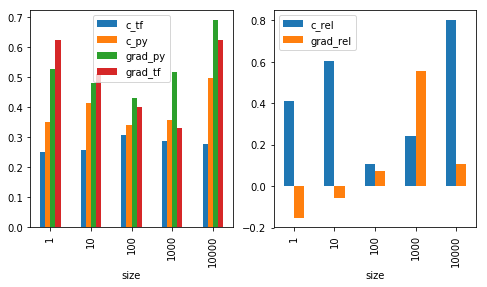

In [21]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

times[['c_tf', 'c_py', 'grad_py', 'grad_tf']].plot.bar(ax=ax1)
times[['c_rel', 'grad_rel']].plot.bar(ax=ax2)

# TODO: run timing when computer is not under load
# TODO: find another function to implement with more work